# Data Quality Report for the month of July 2022

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.insert(0, "..")
from helpers.aws import execute_athena_query

sns.set_theme()

sql = f"""
with site_names as (
    select distinct site_name 
    from lake.weather 
    where year = 2022 and month = 7
),

periods as (
    select distinct date(observation_ts) as ts 
    from lake.weather 
    where year = 2022 and month = 7
),

expected_chunks as (select distinct * from periods, site_names)

select * from (
    select ec.site_name, ec.ts, count(w.temperature) as num_temp_readings 
    from expected_chunks ec
    left outer join lake.weather w 
        on w.site_name = ec.site_name 
        and date(observation_ts) = ec.ts
        and w.year = 2022 
        and w.month = 7
    group by ec.ts, ec.site_name
)
where ts >= date('2022-07-01') and ts < date('2022-08-01')
order by site_name, ts asc
"""

results_url = execute_athena_query(sql, "lake", "dantelore.queryresults")
df = pd.read_csv(results_url)
df['day'] = pd.to_datetime(df['ts']).dt.strftime('%d')



# Hourly readings collected per day this month

This table shows the number of hourly readings gathered per day for each weather station in the dataset.

In [10]:
hex_colors = sns.color_palette("RdYlGn", 25).as_hex()
def cell_colour(x):
    try:
        i = int(x)
    except (ValueError, TypeError):
        return ""

    return f"background-color: {hex_colors[i]}" 

table = df.pivot(index='site_name', columns='day', values='num_temp_readings')

table.style.map(cell_colour)


day,01,02,03,04,05,06,07,08,09,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
site_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ABERDARON,24,24,24,24,24,24,24,24,24,24,22,24,24,24,24,24,24,23,24,24,22,22,24,24,22,24,21,24,24,24,24
ABERDEEN AIRPORT,24,24,24,24,23,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,23,24,24,24,22,24,24,24,24,24,24
ABERPORTH,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,21,24,24,24,24,24,24,24,24,24,24
ABOYNE,24,24,24,24,24,24,24,24,24,24,24,24,21,24,24,24,24,24,24,24,23,24,24,24,22,24,24,24,24,24,24
ALBEMARLE,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,23,24,24,24,23,24,24,24,24,24,24
ALTNAHARRA SAWS,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,23,24,24,23,24,23,24,24,24,21,24,24,24,24,24,24
ANDREWSFIELD,24,24,24,24,24,21,24,24,24,24,24,24,24,24,24,24,23,24,24,24,24,24,24,24,22,24,24,24,24,24,24
AULTBEA,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,23,24,24,24,22,24,24,24,24,24,24
AVIEMORE,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,22,24,24,24,21,24,24,24,24,24,24


In [11]:

sql_dec_2022 = """
select observation_ts, temperature 
from lake.weather
where year = 2022 and month = 12
  and observation_ts >= date('2022-12-01') 
  and observation_ts < date('2023-01-01')
"""

sql_dec_2021 = """
select observation_ts, temperature 
from lake.weather
where year = 2021 and month = 12
  and observation_ts >= date('2021-12-01') 
  and observation_ts < date('2022-01-01')
"""

results_url = execute_athena_query(sql_dec_2022, "lake", "dantelore.queryresults")
this_month = pd.read_csv(results_url)
this_month['day'] = pd.to_datetime(this_month['observation_ts']).dt.strftime('%d')
this_month['temperature'] = pd.to_numeric(this_month['temperature'], errors='coerce')

results_url = execute_athena_query(sql_dec_2021, "lake", "dantelore.queryresults")
comparison_month = pd.read_csv(results_url)
comparison_month['day'] = pd.to_datetime(comparison_month['observation_ts']).dt.strftime('%d')
comparison_month['temperature'] = pd.to_numeric(comparison_month['temperature'], errors='coerce')


# This Month vs Last Year

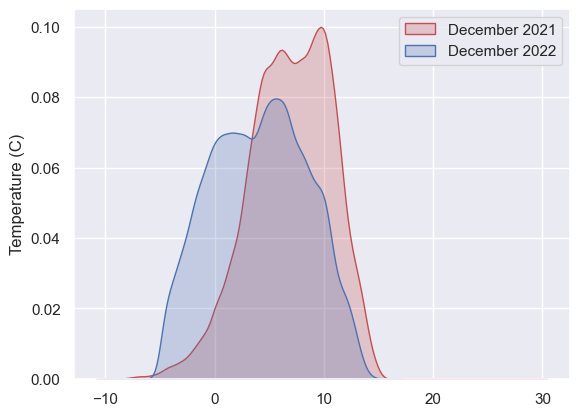

In [12]:
sns.set_theme(style="darkgrid")

sns.kdeplot(data=comparison_month, x="temperature", fill=True, color="r", label="December 2021")
sns.kdeplot(data=this_month, x="temperature", fill=True, color="b", label="December 2022")

plt.xlabel('')
plt.ylabel('Temperature (C)', fontsize=12)
plt.legend(loc='upper right')
plt.show()